In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


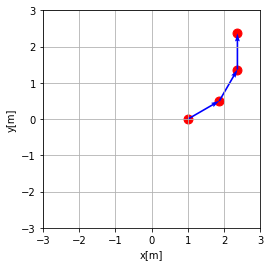

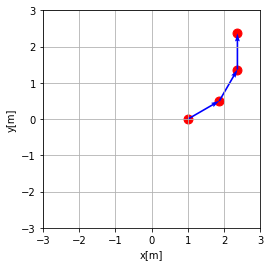

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.5 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :', DATA_RAD_PER_STEP)

X_train = []
for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP) 
    if(len(d) > 10):
        print(rand_rad)
        print(d)
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d)
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 1000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.5
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.05
DATA_RAD_PER_STEP  : 0.6283185307179586
1000
(10, 3)


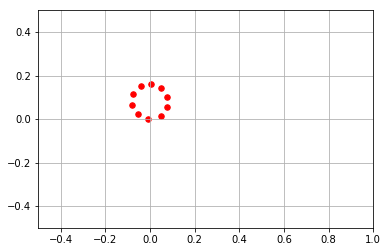

 -- x_train -- 
[[ 4.69027098e-02  1.49067793e-02 -9.55341745e-01]
 [ 7.65931652e-02  5.41566597e-02 -3.39887164e-01]
 [ 7.81756275e-02  1.03345806e-01  2.75567417e-01]
 [ 5.10693681e-02  1.44422891e-01  8.91021999e-01]
 [ 5.22178313e-03  1.62313537e-01  1.50647658e+00]
 [-4.25420805e-02  1.50452273e-01  2.12193116e+00]
 [-7.46939440e-02  1.13191919e-01  2.73738574e+00]
 [-7.94347864e-02  6.42062003e-02  3.35284032e+00]
 [-5.50248238e-02  2.14717881e-02  3.96829491e+00]
 [-1.04219710e-02  6.71264473e-04  4.58374949e+00]]


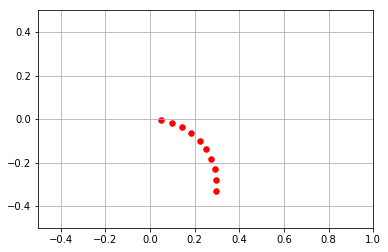

 -- x_train -- 
[[ 0.04976568 -0.00418524 -1.73859914]
 [ 0.09813336 -0.01662337 -1.90640196]
 [ 0.14374429 -0.036965   -2.07420478]
 [ 0.1853172  -0.06463869 -2.24200759]
 [ 0.22168421 -0.09886704 -2.40981041]
 [ 0.25182372 -0.1386885  -2.57761322]
 [ 0.27488906 -0.18298443 -2.74541604]
 [ 0.29023227 -0.23051048 -2.91321886]
 [ 0.29742234 -0.27993155 -3.08102167]
 [ 0.2962573  -0.32985932 -3.24882449]]


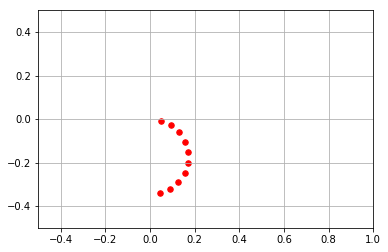

 -- x_train -- 
[[ 0.04930534 -0.00718279 -1.86012056]
 [ 0.09451212 -0.02813408 -2.1494448 ]
 [ 0.13186246 -0.06111228 -2.43876903]
 [ 0.15825158 -0.10337602 -2.72809327]
 [ 0.17148584 -0.15141209 -3.0174175 ]
 [ 0.17046513 -0.20122742 -3.30674174]
 [ 0.1552743  -0.24868106 -3.59606597]
 [ 0.12717611 -0.28982837 -3.88539021]
 [ 0.08850624 -0.32124892 -4.17471444]
 [ 0.04247919 -0.34033085 -4.46403868]]


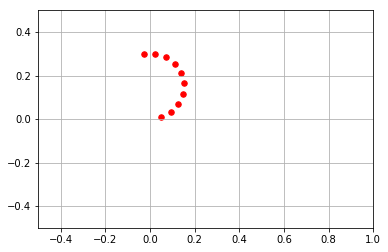

 -- x_train -- 
[[ 0.04908543  0.00822885 -1.23859854]
 [ 0.09280366  0.03201562 -0.90640076]
 [ 0.12637434  0.06875937 -0.57420298]
 [ 0.14612671  0.11444238 -0.2420052 ]
 [ 0.14990097  0.16406948  0.09019258]
 [ 0.13728443  0.21221423  0.42239037]
 [ 0.10965662  0.25361227  0.75458815]
 [ 0.07003849  0.28373698  1.08678593]
 [ 0.02276206  0.29929438  1.41898371]
 [-0.02700327  0.29858337  1.7511815 ]]


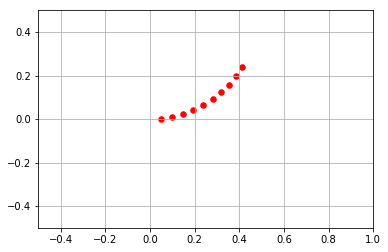

 -- x_train -- 
[[ 0.04990784  0.00262743 -1.46560214]
 [ 0.09926391  0.01048067 -1.36040794]
 [ 0.14752256  0.02347291 -1.25521375]
 [ 0.19415026  0.0414605  -1.15001956]
 [ 0.2386315   0.06424457 -1.04482537]
 [ 0.28047453  0.09157325 -0.93963118]
 [ 0.31921674  0.12314439 -0.83443699]
 [ 0.35442981  0.15860895 -0.7292428 ]
 [ 0.38572444  0.19757485 -0.62404861]
 [ 0.41275465  0.23961131 -0.51885441]]


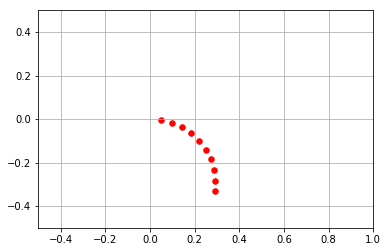

 -- x_train -- 
[[ 0.04975766 -0.00425601 -1.74145033]
 [ 0.09806976 -0.01690038 -1.91210434]
 [ 0.14353271 -0.03756577 -2.08275835]
 [ 0.18482573 -0.06565181 -2.25341235]
 [ 0.22074915 -0.10034253 -2.42406636]
 [ 0.25025934 -0.14063009 -2.59472037]
 [ 0.27249894 -0.18534406 -2.76537437]
 [ 0.28682185 -0.23318539 -2.93602838]
 [ 0.29281196 -0.28276419 -3.10668238]
 [ 0.29029525 -0.33264008 -3.27733639]]


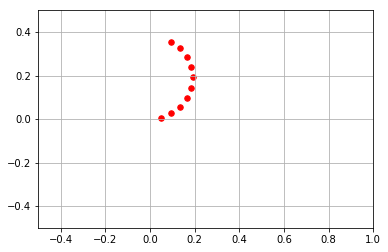

 -- x_train -- 
[[ 0.04942664  0.00653124 -1.30803837]
 [ 0.09546036  0.02567663 -1.04528042]
 [ 0.13494116  0.05612191 -0.78252246]
 [ 0.16515888  0.09577717 -0.51976451]
 [ 0.18403919  0.14192024 -0.25700655]
 [ 0.19028605  0.19138362  0.0057514 ]
 [ 0.18347064  0.24077187  0.26850936]
 [ 0.16406082  0.28669472  0.53126731]
 [ 0.13338897  0.32599977  0.79402527]
 [ 0.09356058  0.35598891  1.05678322]]


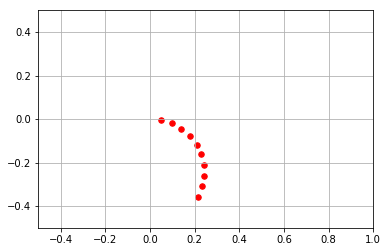

 -- x_train -- 
[[ 0.04965091 -0.00510426 -1.77568252]
 [ 0.09722485 -0.02020353 -1.98056872]
 [ 0.14073169 -0.04466617 -2.18545491]
 [ 0.1783515  -0.07746887 -2.39034111]
 [ 0.20851055 -0.11723944 -2.5952273 ]
 [ 0.22994725 -0.1623142  -2.8001135 ]
 [ 0.24176487 -0.21080761 -3.00499969]
 [ 0.24346904 -0.2606911  -3.20988589]
 [ 0.23498849 -0.30987796 -3.41477209]
 [ 0.21667797 -0.35631062 -3.61965828]]


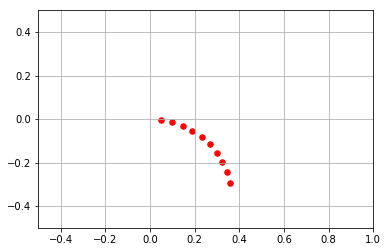

 -- x_train -- 
[[ 0.04984284 -0.00342939 -1.70818794]
 [ 0.09874631 -0.01365293 -1.84557955]
 [ 0.14578873 -0.03047794 -1.98297116]
 [ 0.1900835  -0.05358731 -2.12036277]
 [ 0.23079581 -0.08254552 -2.25775437]
 [ 0.26715836 -0.11680679 -2.39514598]
 [ 0.29848583 -0.15572542 -2.53253759]
 [ 0.32418781 -0.1985679  -2.6699292 ]
 [ 0.34377989 -0.24452679 -2.80732081]
 [ 0.35689283 -0.29273593 -2.94471242]]


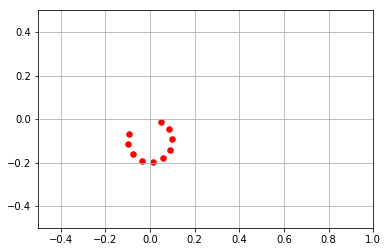

 -- x_train -- 
[[ 0.04790408 -0.01235223 -2.0755089 ]
 [ 0.08386218 -0.0463286  -2.58022147]
 [ 0.09890732 -0.09345633 -3.08493404]
 [ 0.08928764 -0.14198303 -3.58964661]
 [ 0.05740203 -0.17980745 -4.09435918]
 [ 0.01120191 -0.19749721 -4.59907175]
 [-0.03779167 -0.19064095 -5.10378432]
 [-0.07736102 -0.16094844 -5.60849689]
 [-0.09763863 -0.1158242  -6.11320946]
 [-0.09356779 -0.06652098 -6.61792203]]


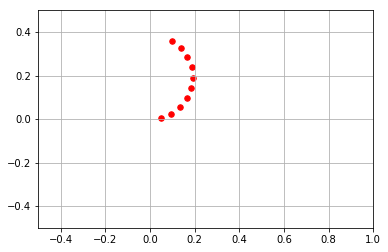

 -- x_train -- 
[[ 0.04943787  0.00646743 -1.31063517]
 [ 0.09554843  0.02543443 -1.05047401]
 [ 0.1352283   0.05562448 -0.79031285]
 [ 0.16580691  0.09500569 -0.53015169]
 [ 0.18522623  0.14092759 -0.26999053]
 [ 0.19217928  0.1902995  -0.00982937]
 [ 0.1861981   0.23979856  0.25033179]
 [ 0.16768524  0.28609332  0.51049295]
 [ 0.13788668  0.32606802  0.77065411]
 [ 0.09880794  0.35703224  1.03081527]]


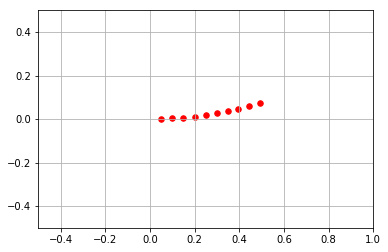

 -- x_train -- 
[[ 4.99926914e-02  7.40330570e-04 -1.54118094e+00]
 [ 9.99415388e-02  2.96067300e-03 -1.51156555e+00]
 [ 1.49802737e-01  6.65908005e-03 -1.48195016e+00]
 [ 1.99532557e-01  1.18323082e-02 -1.45233478e+00]
 [ 2.49087385e-01  1.84758204e-02 -1.42271939e+00]
 [ 2.98423762e-01  2.65837904e-02 -1.39310400e+00]
 [ 3.47498420e-01  3.61491073e-02 -1.36348862e+00]
 [ 3.96268319e-01  4.71633824e-02 -1.33387323e+00]
 [ 4.44690687e-01  5.96169559e-02 -1.30425784e+00]
 [ 4.92723059e-01  7.34989061e-02 -1.27464245e+00]]


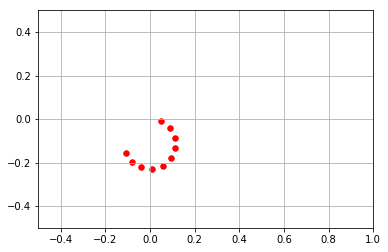

 -- x_train -- 
[[ 0.04843102 -0.01072787 -2.00677304]
 [ 0.08780138 -0.04090445 -2.44274976]
 [ 0.1107455  -0.0848842  -2.87872647]
 [ 0.11297091 -0.1344392  -3.31470319]
 [ 0.09406128 -0.18029852 -3.75067991]
 [ 0.05755429 -0.2138826  -4.18665662]
 [ 0.01027981 -0.2289084  -4.62263334]
 [-0.03891785 -0.22256484 -5.05861005]
 [-0.08083461 -0.1960387  -5.49458677]
 [-0.10762851 -0.15429259 -5.93056349]]


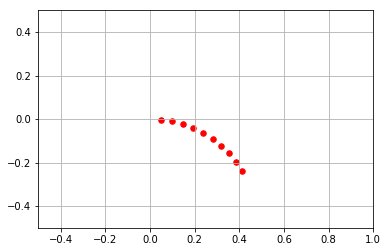

 -- x_train -- 
[[ 4.99091275e-02 -2.60897791e-03 -1.67525038e+00]
 [ 9.92742090e-02 -1.04074719e-02 -1.77970443e+00]
 [ 1.47557129e-01 -2.33104726e-02 -1.88415849e+00]
 [ 1.94231568e-01 -4.11773279e-02 -1.98861254e+00]
 [ 2.38788740e-01 -6.38132760e-02 -2.09306660e+00]
 [ 2.80742941e-01 -9.09715685e-02 -2.19752065e+00]
 [ 3.19636837e-01 -1.22356160e-01 -2.30197470e+00]
 [ 3.55046458e-01 -1.57624936e-01 -2.40642876e+00]
 [ 3.86585812e-01 -1.96393440e-01 -2.51088281e+00]
 [ 4.13911098e-01 -2.38239067e-01 -2.61533686e+00]]


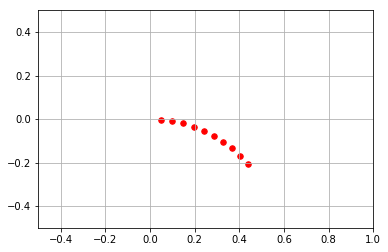

 -- x_train -- 
[[ 4.99359196e-02 -2.19128215e-03 -1.65850382e+00]
 [ 9.94879481e-02 -8.74828274e-03 -1.74621132e+00]
 [ 1.48275146e-01 -1.96205937e-02 -1.83391882e+00]
 [ 1.95922452e-01 -3.47246322e-02 -1.92162631e+00]
 [ 2.42063570e-01 -5.39442833e-02 -2.00933381e+00]
 [ 2.86343783e-01 -7.71317926e-02 -2.09704131e+00]
 [ 3.28422677e-01 -1.04108902e-01 -2.18474880e+00]
 [ 3.67976764e-01 -1.34668221e-01 -2.27245630e+00]
 [ 4.04701966e-01 -1.68574818e-01 -2.36016380e+00]
 [ 4.38315951e-01 -2.05568031e-01 -2.44787129e+00]]


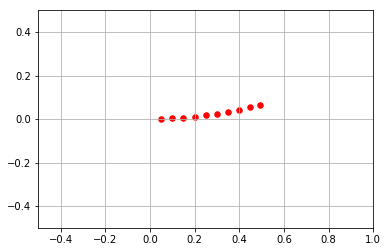

 -- x_train -- 
[[ 4.99939463e-02  6.73785649e-04 -1.54384327e+00]
 [ 9.99515759e-02  2.69465314e-03 -1.51689021e+00]
 [ 1.49836598e-01  6.06113448e-03 -1.48993715e+00]
 [ 1.99612776e-01  1.07707842e-02 -1.46298410e+00]
 [ 2.49243950e-01  1.68201810e-02 -1.43603104e+00]
 [ 2.98694068e-01  2.42049305e-02 -1.40907798e+00]
 [ 3.47927207e-01  3.29196684e-02 -1.38212492e+00]
 [ 3.96907604e-01  4.29580639e-02 -1.35517187e+00]
 [ 4.45599678e-01  5.43128250e-02 -1.32821881e+00]
 [ 4.93968057e-01  6.69757032e-02 -1.30126575e+00]]


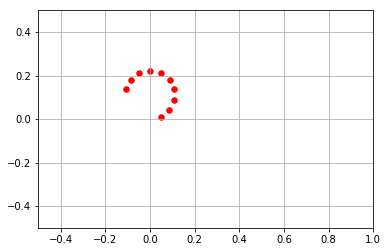

 -- x_train -- 
[[ 4.83413423e-02  1.10231045e-02 -1.12240996e+00]
 [ 8.71253889e-02  4.19131019e-02 -6.74023589e-01]
 [ 1.08684363e-01  8.65629041e-02 -2.25637220e-01]
 [ 1.08755962e-01  1.36145049e-01  2.22749148e-01]
 [ 8.73260290e-02  1.80856929e-01  6.71135517e-01]
 [ 4.86313565e-02  2.11858808e-01  1.11952189e+00]
 [ 3.22051295e-04  2.23021480e-01  1.56790825e+00]
 [-4.80509249e-02  2.12138034e-01  2.01629462e+00]
 [-8.69240222e-02  1.81360177e-01  2.46468099e+00]
 [-1.08611858e-01  1.36772825e-01  2.91306736e+00]]


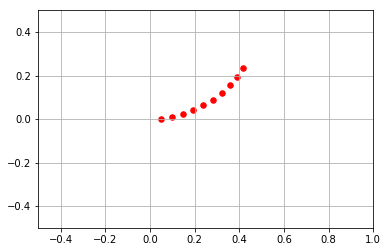

 -- x_train -- 
[[ 0.04991239  0.00256173 -1.46823719]
 [ 0.09930025  0.01022001 -1.36567805]
 [ 0.14764454  0.02289434 -1.26311892]
 [ 0.19443722  0.04045154 -1.16055978]
 [ 0.23918652  0.06270708 -1.05800065]
 [ 0.28142217  0.0894271  -0.95544151]
 [ 0.32070031  0.12033077 -0.85288237]
 [ 0.35660816  0.15509333 -0.75032324]
 [ 0.38876836  0.19334946 -0.6477641 ]
 [ 0.41684293  0.23469711 -0.54520496]]


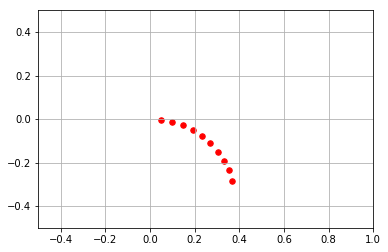

 -- x_train -- 
[[ 0.04985642 -0.00327824 -1.70211457]
 [ 0.09885433 -0.01305651 -1.83343282]
 [ 0.14614999 -0.02916644 -1.96475107]
 [ 0.19092899 -0.05133061 -2.09606931]
 [ 0.23242025 -0.07916736 -2.22738756]
 [ 0.2699093  -0.11219736 -2.3587058 ]
 [ 0.30275059 -0.14985183 -2.49002405]
 [ 0.3303786  -0.19148238 -2.6213423 ]
 [ 0.35231758 -0.23637214 -2.75266054]
 [ 0.36818975 -0.28374812 -2.88397879]]


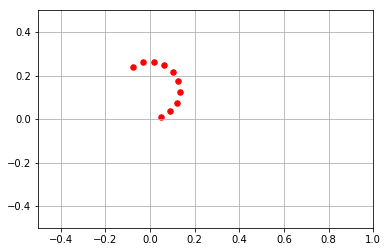

 -- x_train -- 
[[ 0.04882482  0.00931061 -1.19393258]
 [ 0.09079692  0.03593567 -0.81706884]
 [ 0.12002538  0.07613826 -0.44020509]
 [ 0.13240788  0.12427582 -0.06334134]
 [ 0.12620651  0.17359208  0.3135224 ]
 [ 0.10229163  0.21716535  0.69038615]
 [ 0.0640198   0.24887998  1.06724989]
 [ 0.01676257  0.2642847   1.44411364]
 [-0.03284733  0.26121743  1.82097739]
 [-0.07784701  0.24010866  2.19784113]]


In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-.5,1])
    plt.ylim([-.5,.5])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])


In [7]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_different_of_velocity(predict):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    error = F.sum(F.absolute(p))
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def loss_function(y, y_true,dmesg=0):
    z_true = y_true
    z = y[0,0]
    e_distance = error_squares(z,z_true[0])
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        e_distance = e_distance + error_squares(z,z_true[step])
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,step] , DATA_RAD_PER_STEP)
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,step], DATA_M_PER_STEP)
    loss = (10 * e_distance) + (1 * e_lim_w) + (1 * e_lim_v)
    if(dmesg):
        print('e_distance: ' + str(e_distance) + '\t e_lim_w: '  + str(e_lim_w) + '\t e_lim_v: '  + str(e_lim_v))
    return loss

In [8]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 13.67303
Epoch: 2 , Average loss: 8.75524
Epoch: 3 , Average loss: 6.049081
Epoch: 4 , Average loss: 4.9541707
Epoch: 5 , Average loss: 4.366834
Epoch: 6 , Average loss: 4.0572042
Epoch: 7 , Average loss: 3.723422
Epoch: 8 , Average loss: 3.4067748
Epoch: 9 , Average loss: 3.0872028
Epoch: 10 , Average loss: 2.8733952
Epoch: 11 , Average loss: 2.6768537
Epoch: 12 , Average loss: 2.6409414
Epoch: 13 , Average loss: 2.478437
Epoch: 14 , Average loss: 2.376992
Epoch: 15 , Average loss: 2.2476747
Epoch: 16 , Average loss: 2.1765113
Epoch: 17 , Average loss: 2.1363614
Epoch: 18 , Average loss: 2.1320271
Epoch: 19 , Average loss: 2.0544224
Epoch: 20 , Average loss: 2.069011
Epoch: 21 , Average loss: 2.0083547
Epoch: 22 , Average loss: 1.9275616
Epoch: 23 , Average loss: 1.9007062
Epoch: 24 , Average loss: 2.0037634
Epoch: 25 , Average loss: 2.0068948
Epoch: 26 , Average loss: 1.8686923
Epoch: 27 , Average loss: 1.8517896
Epoch: 28 , Average loss: 1.69018
Epoch: 29 , 

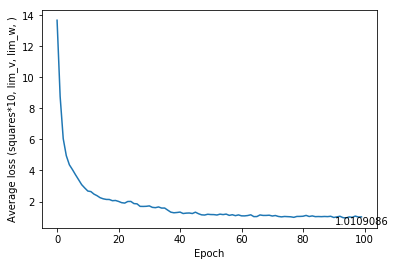

In [9]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [10]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    name_epoch = '{}epoch'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_WAYPOINTS)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 0.0484582  -0.01063661 -2.00294425]
 [ 0.08800671 -0.04059074 -2.43509218]
 [ 0.11137399 -0.08435494 -2.86724011]
 [ 0.11426367 -0.13388255 -3.29938803]
 [ 0.09614442 -0.18006727 -3.73153596]
 [ 0.06034772 -0.21441739 -4.16368389]
 [ 0.01345528 -0.2306172  -4.59583181]
 [-0.0359111  -0.22568813 -5.02797974]
 [-0.07867473 -0.20053647 -5.46012767]
 [-0.10697296 -0.15978668 -5.89227559]]
 --- output --- 
[[[ 0.0475454   0.         -0.70966005]
  [ 0.05526926  0.         -0.4508067 ]
  [ 0.05183123  0.         -0.36109966]
  [ 0.05083392  0.         -0.41246027]
  [ 0.05142409  0.         -0.44964626]
  [ 0.04845007  0.         -0.4485938 ]
  [ 0.04737729  0.         -0.44749022]
  [ 0.04618755  0.         -0.4332206 ]
  [ 0.04577332  0.         -0.41019338]
  [ 0.05401046  0.         -0.1259523 ]]]
[[-40.660526  -25.829323  -20.689487  -23.632233  -25.762833  -25.702532
  -25.639301  -24.821712  -23.50235    -7.2165356]]
 --- error --- 
e_distance: variable(0.04616962)	

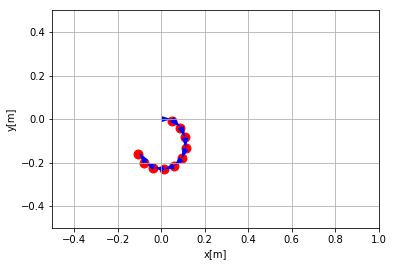

 --- grad --- 
variable([[[ 5.65039921e+00 -6.86025858e-01]
           [ 1.45440235e+01  2.63631344e-03]
           [ 1.54895802e+01 -2.94516504e-01]
           [ 1.96895714e+01 -8.95293295e-01]
           [ 9.13596821e+00 -1.86303914e+00]
           [-2.78341007e+01 -2.37764215e+00]
           [-3.83518982e+01 -2.02267122e+00]
           [-2.46195354e+01 -1.28649545e+00]
           [-1.02653761e+01 -5.36834657e-01]
           [ 2.10987110e+01  0.00000000e+00]]])


In [11]:
rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
x_test = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, dmesg=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true,[-.5,1],[-.5,.5])
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

 --- input --- 
[[ 0.04948078 -0.00621761 -1.8208002 ]
 [ 0.09588498 -0.02448385 -2.07080408]
 [ 0.13632734 -0.05366298 -2.32080796]
 [ 0.16829326 -0.09194072 -2.57081184]
 [ 0.1897952  -0.13693708 -2.82081571]
 [ 0.19949623 -0.18585432 -3.07081959]
 [ 0.19679317 -0.2356509  -3.32082347]
 [ 0.18185408 -0.28323062 -3.57082735]
 [ 0.15560784 -0.3256351  -3.82083122]
 [ 0.11968636 -0.36022778 -4.0708351 ]]
 --- output --- 
[[[ 0.04982559  0.         -0.4440517 ]
  [ 0.05379437  0.         -0.26448143]
  [ 0.05114355  0.         -0.20469335]
  [ 0.05050254  0.         -0.23661438]
  [ 0.05135104  0.         -0.25993764]
  [ 0.04890165  0.         -0.25557712]
  [ 0.04773233  0.         -0.25825354]
  [ 0.04710637  0.         -0.25075445]
  [ 0.04623418  0.         -0.23883982]
  [ 0.05248843  0.         -0.12566045]]]
 --- error --- 
loss: variable(0.00622717)
loss: variable(0.00286827)
loss: variable(0.00287507)
loss: variable(0.00442539)
loss: variable(0.00633266)
loss: variable(0.006201

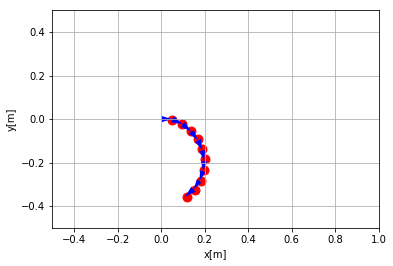

 --- input --- 
[[ 0.049816    0.00371    -1.42212253]
 [ 0.09853291  0.01475816 -1.27344873]
 [ 0.14507586  0.03290071 -1.12477493]
 [ 0.18841797  0.05773737 -0.97610112]
 [ 0.22760297  0.08872017 -0.82742732]
 [ 0.26176633  0.12516553 -0.67875352]
 [ 0.29015427  0.16626933 -0.53007972]
 [ 0.31214048  0.21112471 -0.38140592]
 [ 0.32723987  0.25874201 -0.23273212]
 [ 0.33511929  0.30807063 -0.08405832]]
 --- output --- 
[[[ 0.0514485   0.          0.25519553]
  [ 0.05125488  0.          0.12527275]
  [ 0.05038332  0.          0.11102179]
  [ 0.05022903  0.          0.1213115 ]
  [ 0.05033786  0.          0.13117158]
  [ 0.04988416  0.          0.14001915]
  [ 0.04868439  0.          0.1325615 ]
  [ 0.04822164  0.          0.12530737]
  [ 0.04730679  0.          0.11339403]
  [ 0.04829368  0.         -0.13087192]]]
 --- error --- 
loss: variable(0.00405329)
loss: variable(0.00310063)
loss: variable(0.00301983)
loss: variable(0.00439241)
loss: variable(0.00719565)
loss: variable(0.010849

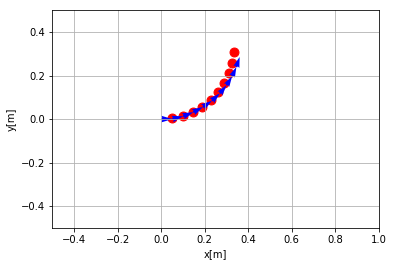

 --- input --- 
[[ 0.04816233 -0.01158778 -2.04301774]
 [ 0.0857829  -0.04381479 -2.51523915]
 [ 0.10462731 -0.08962718 -2.98746056]
 [ 0.10057091 -0.13899754 -3.45968197]
 [ 0.07450155 -0.18111969 -3.93190338]
 [ 0.0321253  -0.20677394 -4.4041248 ]
 [-0.01728253 -0.21034509 -4.87634621]
 [-0.06290757 -0.19105148 -5.34856762]
 [-0.0947634  -0.1531161  -5.82078903]
 [-0.10587742 -0.10484224 -6.29301044]]
 --- output --- 
[[[ 0.04669095  0.         -0.7613065 ]
  [ 0.05566039  0.         -0.49600473]
  [ 0.05212835  0.         -0.40063524]
  [ 0.05104189  0.         -0.45626888]
  [ 0.05153692  0.         -0.4961498 ]
  [ 0.0483102   0.         -0.496086  ]
  [ 0.04734445  0.         -0.49412453]
  [ 0.04599136  0.         -0.4778951 ]
  [ 0.04567664  0.         -0.4521839 ]
  [ 0.05448004  0.         -0.12699877]]]
 --- error --- 
loss: variable(0.01168082)
loss: variable(0.00554837)
loss: variable(0.00226882)
loss: variable(0.00195981)
loss: variable(0.00312228)
loss: variable(0.001919

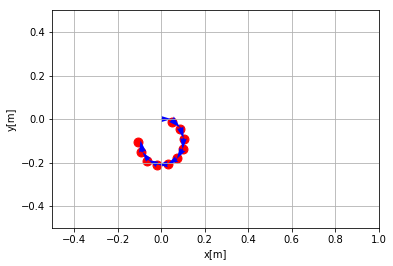

 --- input --- 
[[ 0.04976339  0.00420556 -1.40217496]
 [ 0.09811521  0.01670293 -1.23355359]
 [ 0.1436839   0.03713762 -1.06493222]
 [ 0.18517687  0.06492998 -0.89631085]
 [ 0.22141714  0.09929165 -0.72768948]
 [ 0.25137672  0.13924794 -0.55906811]
 [ 0.27420579  0.18366546 -0.39044674]
 [ 0.28925678  0.23128426 -0.22182537]
 [ 0.29610274  0.28075359 -0.053204  ]
 [ 0.2945495   0.33067021  0.11541737]]
 --- output --- 
[[[ 0.05141275  0.          0.29039764]
  [ 0.05120467  0.          0.14603312]
  [ 0.05037956  0.          0.12802419]
  [ 0.0502028   0.          0.14023462]
  [ 0.05028564  0.          0.1515405 ]
  [ 0.04989402  0.          0.16046844]
  [ 0.04870156  0.          0.15286912]
  [ 0.04822971  0.          0.14508991]
  [ 0.0473244   0.          0.13206404]
  [ 0.0481601   0.         -0.13157584]]]
 --- error --- 
loss: variable(0.00451742)
loss: variable(0.00311906)
loss: variable(0.00271664)
loss: variable(0.0039788)
loss: variable(0.00669312)
loss: variable(0.0102405

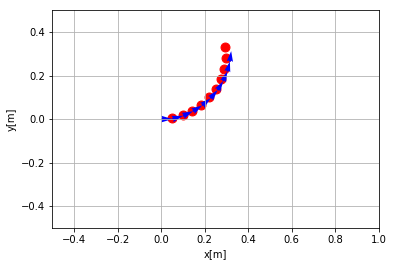

 --- input --- 
[[ 4.99698877e-02  1.50248778e-03 -1.51067871e+00]
 [ 9.97592323e-02  6.00452256e-03 -1.45056110e+00]
 [ 1.49188143e-01  1.34898383e-02 -1.39044348e+00]
 [ 1.98078031e-01  2.39313903e-02 -1.33032587e+00]
 [ 2.46252255e-01  3.72914528e-02 -1.27020825e+00]
 [ 2.93536760e-01  5.35217554e-02 -1.21009064e+00]
 [ 3.39760705e-01  7.25636573e-02 -1.14997302e+00]
 [ 3.84757082e-01  9.43483594e-02 -1.08985541e+00]
 [ 4.28363316e-01  1.18797153e-01 -1.02973779e+00]
 [ 4.70421857e-01  1.45821703e-01 -9.69620177e-01]]
 --- output --- 
[[[ 0.05091913  0.          0.09344375]
  [ 0.05145543  0.          0.03646154]
  [ 0.05048889  0.          0.04020717]
  [ 0.05016376  0.          0.04051672]
  [ 0.05025502  0.          0.04213302]
  [ 0.04960894  0.          0.05030616]
  [ 0.04854176  0.          0.04518979]
  [ 0.04811737  0.          0.04018311]
  [ 0.04739838  0.          0.03385311]
  [ 0.04806392  0.         -0.12953794]]]
 --- error --- 
loss: variable(0.00177723)
loss: varia

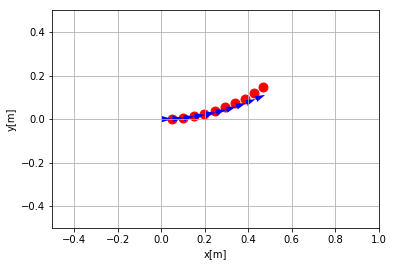

 --- input --- 
[[ 4.69005343e-02 -1.49117757e-02 -2.18647120e+00]
 [ 7.65776810e-02 -5.41710183e-02 -2.80214607e+00]
 [ 7.81330357e-02 -1.03360469e-01 -3.41782094e+00]
 [ 5.09954220e-02 -1.44416176e-01 -4.03349581e+00]
 [ 5.13064608e-03 -1.62261161e-01 -4.64917068e+00]
 [-4.26182684e-02 -1.50342171e-01 -5.26484555e+00]
 [-7.47163815e-02 -1.13036242e-01 -5.88052042e+00]
 [-7.93762316e-02 -6.40433144e-02 -6.49619530e+00]
 [-5.48865717e-02 -2.13551694e-02 -7.11187017e+00]
 [-1.02407941e-02 -6.48269418e-04 -7.72754504e+00]]
 --- output --- 
[[[ 0.04992203  0.         -0.8745045 ]
  [ 0.0520047   0.         -0.63927674]
  [ 0.0511825   0.         -0.5395504 ]
  [ 0.05123852  0.         -0.5934137 ]
  [ 0.05176359  0.         -0.6315075 ]
  [ 0.04855684  0.         -0.6306354 ]
  [ 0.04839107  0.         -0.6255844 ]
  [ 0.04877006  0.         -0.6139406 ]
  [ 0.04817244  0.         -0.58612657]
  [ 0.04906792  0.         -0.11002454]]]
 --- error --- 
loss: variable(0.01521481)
loss: varia

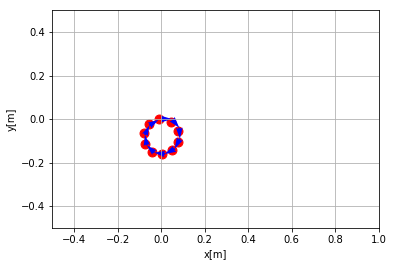

 --- input --- 
[[ 0.0490037   0.00858368 -1.22398705]
 [ 0.09217225  0.0333126  -0.87717778]
 [ 0.12436529  0.07124215 -0.53036851]
 [ 0.14174942  0.11785582 -0.18355923]
 [ 0.1422546   0.16760306  0.16325004]
 [ 0.12582068  0.21456015  0.51005932]
 [ 0.09440454  0.25313565  0.85686859]
 [ 0.05174709  0.27873613  1.20367786]
 [ 0.0029278   0.28831319  1.55048714]
 [-0.04624011  0.28072644  1.89729641]]
 --- output --- 
[[[ 0.05126828  0.          0.6021385 ]
  [ 0.05078883  0.          0.34755692]
  [ 0.05003793  0.          0.29482183]
  [ 0.05042383  0.          0.32546577]
  [ 0.0489301   0.          0.35292426]
  [ 0.05128687  0.          0.36232185]
  [ 0.04931707  0.          0.3523649 ]
  [ 0.04752873  0.          0.33836344]
  [ 0.04722271  0.          0.31462651]
  [ 0.04685426  0.         -0.13468483]]]
 --- error --- 
loss: variable(0.00887738)
loss: variable(0.00464421)
loss: variable(0.00277117)
loss: variable(0.00340349)
loss: variable(0.00407608)
loss: variable(0.005070

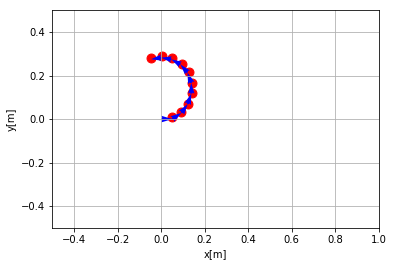

 --- input --- 
[[ 4.99853364e-02  1.04859172e-03 -1.52884651e+00]
 [ 9.98827221e-02  4.19252187e-03 -1.48689669e+00]
 [ 1.49604361e-01  9.42625859e-03 -1.44494687e+00]
 [ 1.99062767e-01  1.67405930e-02 -1.40299704e+00]
 [ 2.48170916e-01  2.61226553e-02 -1.36104722e+00]
 [ 2.96842401e-01  3.75559374e-02 -1.31909740e+00]
 [ 3.44991583e-01  5.10203222e-02 -1.27714758e+00]
 [ 3.92533743e-01  6.64921187e-02 -1.23519776e+00]
 [ 4.39385227e-01  8.39441039e-02 -1.19324794e+00]
 [ 4.85463601e-01  1.03345570e-01 -1.15129812e+00]]
 --- output --- 
[[[ 0.05073295  0.          0.0611941 ]
  [ 0.05147891  0.          0.01952728]
  [ 0.05050944  0.          0.02698967]
  [ 0.05011547  0.          0.02517903]
  [ 0.05017195  0.          0.02495136]
  [ 0.04953011  0.          0.03297551]
  [ 0.04850537  0.          0.02859751]
  [ 0.04808442  0.          0.02389801]
  [ 0.04744853  0.          0.01870308]
  [ 0.04785741  0.         -0.1294213 ]]]
 --- error --- 
loss: variable(0.00128781)
loss: varia

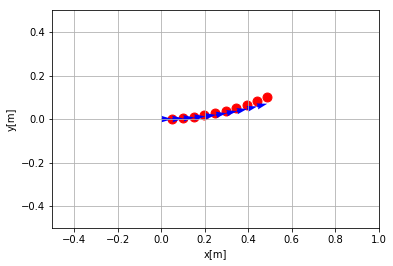

 --- input --- 
[[ 0.04949348 -0.00614165 -1.81771435]
 [ 0.09598471 -0.02419406 -2.06463237]
 [ 0.13665357 -0.05306217 -2.31155039]
 [ 0.16903311 -0.09099486 -2.55846841]
 [ 0.19115921 -0.13569117 -2.80538643]
 [ 0.2016897  -0.18443984 -3.05230446]
 [ 0.19998583 -0.2342838  -3.29922248]
 [ 0.18615094 -0.28219956 -3.5461405 ]
 [ 0.16102426 -0.32528057 -3.79305852]
 [ 0.12612994 -0.36091357 -4.03997654]]
 --- output --- 
[[[ 0.04980603  0.         -0.43901616]
  [ 0.05376327  0.         -0.26122928]
  [ 0.05114697  0.         -0.2019697 ]
  [ 0.05050852  0.         -0.23362775]
  [ 0.0513402   0.         -0.2567474 ]
  [ 0.04890753  0.         -0.25237283]
  [ 0.04774881  0.         -0.255046  ]
  [ 0.04712246  0.         -0.24760057]
  [ 0.04625474  0.         -0.23580335]
  [ 0.05242423  0.         -0.12580974]]]
 --- error --- 
loss: variable(0.0061496)
loss: variable(0.00282531)
loss: variable(0.00290185)
loss: variable(0.00445294)
loss: variable(0.00634612)
loss: variable(0.0062212

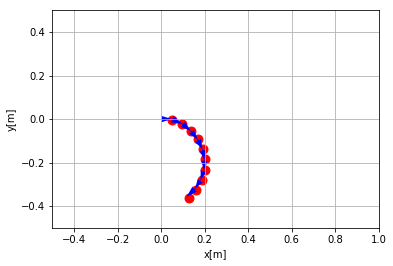

 --- input --- 
[[ 0.04990258 -0.00270121 -1.67895023]
 [ 0.099222   -0.01077329 -1.78710414]
 [ 0.14738193 -0.02412189 -1.89525804]
 [ 0.19381958 -0.04259103 -2.00341194]
 [ 0.23799227 -0.06596489 -2.11156585]
 [ 0.27938382 -0.09397032 -2.21971975]
 [ 0.31751052 -0.12628005 -2.32787366]
 [ 0.35192684 -0.16251651 -2.43602756]
 [ 0.38223058 -0.20225625 -2.54418147]
 [ 0.40806763 -0.24503487 -2.65233537]]
 --- output --- 
[[[ 0.05166762  0.         -0.1963197 ]
  [ 0.05070989  0.         -0.13252261]
  [ 0.04996321  0.         -0.09838038]
  [ 0.05057491  0.         -0.11183386]
  [ 0.04939196  0.         -0.11877634]
  [ 0.05065865  0.         -0.11083566]
  [ 0.04908624  0.         -0.11313446]
  [ 0.04802437  0.         -0.1184831 ]
  [ 0.04793851  0.         -0.11636171]
  [ 0.04628707  0.         -0.11818928]]]
 --- error --- 
loss: variable(0.00322675)
loss: variable(0.0023529)
loss: variable(0.00231066)
loss: variable(0.00448254)
loss: variable(0.00643305)
loss: variable(0.0095925

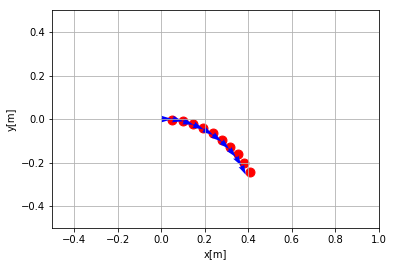

In [12]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    x_test = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true,[-.5,1],[-.5,.5])
    fig.savefig(dirname + '/test' + str(i) + '.png')